In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import scipy
from dateutil.relativedelta import relativedelta
import MH4518.WY.Utils.constants as cs
import MH4518.WY.Utils.Dates as dates 
import MH4518.WY.Utils.payoff as pf
import MH4518.WY.Utils.GBM as gbm
import MH4518.WY.Utils.ProductPrice as pp 

import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp
import pandas as pd
import logging


In [20]:
def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()
data

[*********************100%***********************]  2 of 2 completed


Ticker,LONN.SW,SIKA.SW
Date,,
2023-04-27,542.120483,237.429871
2023-04-28,546.263367,242.368103
2023-05-02,545.868896,239.800232
2023-05-03,574.079590,241.479218
2023-05-04,572.895935,242.071823
...,...,...
2024-07-24,522.599976,262.000000
2024-07-25,559.799988,258.500000
2024-07-26,581.000000,262.000000


In [4]:
def multi_asset_gbm(data: pd.DataFrame, fdos, nsims: int) -> pd.DataFrame:
    """
    Simulates multiple asset paths under the risk-neutral measure using GBM for multiple simulations.
    """

    try:
        # Prepare the log returns DataFrame
        log_returns_df = pd.DataFrame()
        for ticker in cs.ticker_list:
            log_returns = np.log(data[ticker] / data[ticker].shift(1))
            log_returns_df[ticker] = log_returns
        log_returns_df.dropna(inplace=True)
        
        # Compute the covariance matrix of log returns
        cov_matrix = log_returns_df.cov().values
        vol_vector = np.sqrt(np.diag(cov_matrix))
        corr_matrix = cov_matrix / np.outer(vol_vector, vol_vector)
        L = np.linalg.cholesky(corr_matrix)
        
    except Exception as e:
        print("Error at covariance matrix computation:", e)
        raise
    
    try:
        # Simulation parameters
        date_list = dates.get_list_dates(fdos, cs.final_fixing_date)
        num_steps = len(date_list)  # Number of time steps
        dt = cs.dt  # Time step in years
        
        num_assets = cs.num_ticker  # Number of assets
        
        s0_vector = data.loc[fdos, cs.ticker_list].values  # Initial prices as NumPy array
        
        # Print lengths
        print(f"Length of date_list: {len(date_list)}")
        print(f"Number of time steps (num_steps): {num_steps}")
        
        # Precompute drift terms
        drift = (cs.interest_rate - 0.5 * vol_vector ** 2) * dt  # Shape: (num_assets,)
        #drift_rnv = (cs.interest_rate) * dt  # risk neutral drift
        
        # Generate random variables
        Z = np.random.normal(size=(num_steps - 1, nsims, num_assets))  # Shape: (num_steps-1, nsims, num_assets)
        Z_reshaped = Z.reshape(-1, num_assets)  # Shape: ((num_steps - 1) * nsims, num_assets)
        epsilon = Z_reshaped @ L.T  # Shape: ((num_steps - 1) * nsims, num_assets)
        epsilon = epsilon.reshape(num_steps - 1, nsims, num_assets)  # Shape: (num_steps - 1, nsims, num_assets)
        epsilon = epsilon * np.sqrt(dt)  # Scale by sqrt(dt)
        
        # Initialize array to hold simulated prices
        S = np.zeros((num_steps, nsims, num_assets))  # Shape: (num_steps, nsims, num_assets)
        S[0, :, :] = s0_vector  # Set initial prices for all simulations
        
        # Simulate asset prices
        for t in range(1, num_steps):
            S[t] = S[t - 1] * np.exp(
                drift + vol_vector * epsilon[t - 1]
            )
        
        # Transpose S to shape (num_steps, num_assets, nsims)
        S_transposed = S.transpose(0, 2, 1)  # Swap axes 1 and 2
        
        # Reshape S_transposed to (num_steps, num_assets * nsims)
        S_reshaped = S_transposed.reshape(num_steps, num_assets * nsims)
        
        # Build MultiIndex columns
        assets = cs.ticker_list
        simulations = [f'sim{n+1}' for n in range(nsims)]
        arrays = [[], []]
        for asset in assets:
            for sim in simulations:
                arrays[0].append(asset)
                arrays[1].append(sim)
        tuples = list(zip(*arrays))
        index = pd.MultiIndex.from_tuples(tuples, names=['Asset', 'Simulation'])
        
        # Create DataFrame
        sim_data = pd.DataFrame(S_reshaped, index=date_list)
        sim_data.columns = index
        
    except Exception as e:
        print("Error during simulation:", e)
        raise
        
    return sim_data

def multi_asset_gbm_n_sims(plot: bool, plotasset: bool, nsims: int, data: pd.DataFrame, fdos) -> pd.DataFrame:
    """
    Simulate multiple asset paths under the GBM model for 'nsims' simulations starting from 'fdos'.

    Params:
        plot (bool): Whether to plot the combined simulations.
        plotasset (bool): Whether to plot the simulations for each asset separately.
        nsims (int): Number of simulations to run.
        data (pd.DataFrame): Historical data for assets.
        fdos: First date of simulation.

    Returns:
        sim_data: DataFrame containing simulated asset prices for all simulations.
                  Columns are MultiIndex with levels ('Asset', 'Simulation')
    """

    # Get the list of dates for the simulation period
    date_list = dates.get_list_dates(fdos, cs.final_fixing_date)
    
    # Realized price from initial fixing date to final fixing date
    realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    
    try:
        # Run the simulation
        sim_data = multi_asset_gbm(data, fdos, nsims)
        sim_data.index = date_list
        
    except Exception as e:
        raise Exception("Error during simulation") from e

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        # Plot the realized prices
        realised_price.plot(ax=ax, linewidth=2)
        # Plot the simulated paths
        for asset in cs.ticker_list:
            asset_columns = sim_data[asset]
            asset_columns.plot(ax=ax, alpha=0.4, legend=False)
        plt.title('Simulated Paths with Realized Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()

    if plotasset:
        for asset in cs.ticker_list:
            # Select columns for the asset
            asset_columns = sim_data[asset]
            # Select the realized price for the asset
            realised_price_asset = realised_price[asset]  # Adjust the column name if necessary

            # Plot asset paths and realized price
            fig, ax = plt.subplots(figsize=(12, 6))
            asset_columns.plot(ax=ax, alpha=0.4, legend=False)
            realised_price_asset.plot(ax=ax, color='black', linewidth=2, label=f'Realized Price {asset}')
            ax.legend()
            plt.title(f'{asset} Paths under Multi Asset GBM')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.grid(True)
            plt.show()
            
    return sim_data


In [4]:
sim_data = multi_asset_gbm_n_sims(plot= False, plotasset=False, nsims= 1000, data = data, fdos = cs.initial_fixing_date)
lonza_path = sim_data['LONN.SW']
sika_path = sim_data['SIKA.SW']
params = {
      # days
    'Denomination': 1000,   # currency units
    'Coupon_Rate': 0.08/4     # 8% annual coupon
}

Length of date_list: 315
Number of time steps (num_steps): 315


In [23]:
payoff = pf.payoff(lonza_path, sika_path, params, cs.initial_fixing_date)

In [27]:
def payoff_perturbed(paths1, paths2, params, fdos, h, perturb_asset='Lonza', direction=0):
    """
    Calculates the payoff for each simulation based on the product conditions with perturbations.
    
    Params:
        paths1: DataFrame of simulated paths for Lonza (columns: simulations)
        paths2: DataFrame of simulated paths for Sika (columns: simulations)
        params: Dictionary containing product parameters
        fdos: First date of simulation (pricing date)
        h: Perturbation factor
        perturb_asset: The asset to perturb ('Lonza' or 'Sika')
        direction: Perturbation direction (-1 for down, 1 for up, 0 for base)
    
    Returns:
        payoffs: Array of payoffs for each simulation
    """
    
    
    perturbed_paths1 = paths1.copy()
    perturbed_paths2 = paths2.copy()
    
    # Apply perturbation
    if perturb_asset == 'Lonza':
        perturbed_paths1 = paths1 * (1 + direction * h)
    elif perturb_asset == 'Sika':
        perturbed_paths2 = paths2 * (1 + direction * h)
    else:
        raise ValueError("perturb_asset must be 'Lonza' or 'Sika'")
    
    
    payoffs = pf.payoff(perturbed_paths1, perturbed_paths2, params, fdos)
    return payoffs
def delta(price_arr, S0, h):
    return (price_arr[1] - price_arr[2]) / (2 * h * S0)

def gamma(price_arr, S0, h):
    return (price_arr[1] - 2 * price_arr[0] + price_arr[2]) / (S0 * (h ** 2))


def calculate_greeks(paths1, paths2, params, fdos, h, perturb_asset='Lonza'):
    # Determine S0 based on the asset being perturbed
    if perturb_asset == 'Lonza':
        S0 = paths1.iloc[0, 0]  # Assuming all simulations start with the same initial price
    elif perturb_asset == 'Sika':
        S0 = paths2.iloc[0, 0]
    else:
        raise ValueError("perturb_asset must be 'Lonza' or 'Sika'")
    
    P_base = pf.payoff(paths1, paths2, params, fdos)
    P_up = payoff_perturbed(paths1, paths2, params, fdos, h, perturb_asset, direction=1)
    P_down = payoff_perturbed(paths1, paths2, params, fdos, h, perturb_asset, direction=-1)
    
    deltas = delta([P_base, P_up, P_down], S0, h)
    
    
    return deltas

def calculate_greeks_multi_asset(paths1, paths2, params, fdos, h, perturb_assets=['Lonza', 'Sika']):
    greeks_dict = {}
    for asset in perturb_assets:
        deltas, gammas = calculate_greeks(paths1, paths2, params, fdos, h, perturb_asset=asset)
        greeks_dict[asset] = {'Delta': deltas, 'Gamma': gammas}
    return greeks_dict

# Simulation Parameters
h = 0.01  # 1%
perturb_assets = ['Lonza', 'Sika']
params = {
    'Settlement_Delay': 2,  # days
    'Denomination': 1000,   # currency units
    'Coupon_Rate': 0.08/4     # 5% annual coupon
}

# Risk Managemgent, Constructing Delta Neutral Portfolio 

In [ ]:
def construct_full_delta_neutral_portfolio(paths1, paths2, params, fdos, h):
    """
    Constructs a fully delta-neutral portfolio using Product P and Assets S1 and S2.
    
    Params:
        paths1: DataFrame of simulated paths for Lonza (columns: simulations)
        paths2: DataFrame of simulated paths for Sika (columns: simulations)
        params: Dictionary containing product parameters
        fdos: First date of simulation (pricing date)
        h: Perturbation factor for Greek calculations
        
    Returns:
        portfolio: Dictionary indicating holdings of Product P, S1, and S2
        portfolio_delta_S1: Total delta with respect to S1
        portfolio_delta_S2: Total delta with respect to S2
    """
    # Calculate deltas and gammas for both assets
    greeks_dict = calculate_greeks_multi_asset(paths1, paths2, params, fdos, h, perturb_assets=['Lonza', 'Sika'])
    delta_P_S1 = greeks_dict['Lonza']['Delta']
    delta_P_S2 = greeks_dict['Sika']['Delta']
    
    # Number of units to hold for delta neutrality
    x = -delta_P_S1  # Units of S1
    y = -delta_P_S2  # Units of S2
    
    # Construct the portfolio
    portfolio = {
        'Product_P': 1,     
        'S1_Lonza': x,       
        'S2_Sika': y         
    }
    
    # Calculate total portfolio deltas to verify neutrality
    portfolio_delta_S1 = delta_P_S1 + (1 * x)  # Should be close to 0
    portfolio_delta_S2 = delta_P_S2 + (1 * y)  # Should be close to 0
    
    return portfolio, portfolio_delta_S1, portfolio_delta_S2



In [76]:
portfolio, portfolio_delta_S1, portfolio_delta_S2 = construct_full_delta_neutral_portfolio(lonza_path, sika_path, params= params, fdos= cs.initial_fixing_date, h = h )

print("Portfolio Holdings:", portfolio)
print(f"Portfolio Delta S1: {portfolio_delta_S1}")
print(f"Portfolio Delta S2: {portfolio_delta_S2}")

Portfolio Holdings: {'Product_P': 1, 'S1_Lonza': array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.77799767e+00, -0.00000000e+00,
       -1.10898034e+00, -0.00000000e+00, -0.00000000e+00, -5.19789486e-02,
       -1.82331767e+00, -1.79937554e+00, -9.01910009e-01, -0.00000000e+00,
       -0.00000000e+00, -6.65507279e-01, -5.37367553e-01, -1.79312685e+00,
       -0.00000000e+00, -4.66765438e-01, -1.79999063e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.51194807e-01, -0.00000000e+00, -0.00000000e+00, -2.39090721e-01,
       -0.00000000e+00, -1.80962369e+00, -0.00000000e+00, -0.00000000e+00,
       -2.70568572e-01, -1.44163263e+00, -0.00000000e+00, -0.00000000e+00,
       -7.57009187e-01, -1.77131198e+00, -0.00000000e+00, -0.00000000e+00,
       -1.81228606e+00, -1.80045175e+00, -1.81754140e+00, -0.00000000e+00,
       -1.57450368e+00, -1.32377796e+00, -9.4747270

In [85]:
def calculate_static_portfolio_value(lonza_paths_df, sika_paths_df, payoffs_P, holding_S1, holding_S2):
    """
    Calculate the portfolio value over time for a static hedging strategy.

    Params:
        lonza_paths_df (pd.DataFrame): Simulated paths for Lonza (timesteps, simulations)
        sika_paths_df (pd.DataFrame): Simulated paths for Sika (timesteps, simulations)
        payoffs_P (np.ndarray or pd.Series): Payoff array for Product P at maturity (simulations,)
        holding_S1 (np.ndarray): Static holdings in S1 (simulations,)
        holding_S2 (np.ndarray): Static holdings in S2 (simulations,)

    Returns:
        portfolio_values_df (pd.DataFrame): Portfolio values over time (timesteps, simulations)
    """
    holding_S1 = np.array(holding_S1)
    holding_S2 = np.array(holding_S2)
    
    # Multiply holdings by asset prices
    contribution_S1 = lonza_paths_df.multiply(holding_S1, axis=1)
    contribution_S2 = sika_paths_df.multiply(holding_S2, axis=1)
    
    # Portfolio value is the sum of contributions
    portfolio_values_df = contribution_S1 + contribution_S2
    
    # Add Product P's payoff at maturity (last timestep)
    portfolio_values_df.iloc[-1, :] += payoffs_P
    
    return portfolio_values_df


def plot_average_portfolio_vs_assets(portfolio_values_df, lonza_paths_df, sika_paths_df, date_list):
    """
    Plot the average portfolio value over time alongside average asset prices.

    Params:
        portfolio_values_df (pd.DataFrame): Portfolio values over time (timesteps, simulations)
        lonza_paths_df (pd.DataFrame): Simulated paths for Lonza (timesteps, simulations)
        sika_paths_df (pd.DataFrame): Simulated paths for Sika (timesteps, simulations)
        date_list (list): List of dates corresponding to each timestep
    """
    average_portfolio = portfolio_values_df.mean(axis=1)
    average_lonza = lonza_paths_df.mean(axis=1)
    average_sika = sika_paths_df.mean(axis=1)
    
    plt.figure(figsize=(14, 7))
    plt.plot(date_list, average_portfolio, label='Average Portfolio Value', color='blue')
    plt.plot(date_list, data['LONN.SW'].iloc[1:], label='Lonza Price (S1)', color='green')
    plt.plot(date_list, data['SIKA.SW'].iloc[1:], label='Sika Price (S2)', color='orange')
    plt.title('Average Delta-Neutral Portfolio Value vs. Asset Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_final_portfolio_distribution(portfolio_values_df):
    """
    Plot the distribution of final portfolio values across all simulations.

    Params:
        portfolio_values_df (pd.DataFrame): Portfolio values over time (timesteps, simulations)
    """
    final_portfolio = portfolio_values_df.iloc[-1, :]
    
    plt.figure(figsize=(10, 6))
    plt.hist(final_portfolio, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Final Portfolio Values at Maturity')
    plt.xlabel('Portfolio Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [71]:
portfolio['S1_Lonza']

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.77799767e+00, -0.00000000e+00,
       -1.10898034e+00, -0.00000000e+00, -0.00000000e+00, -5.19789486e-02,
       -1.82331767e+00, -1.79937554e+00, -9.01910009e-01, -0.00000000e+00,
       -0.00000000e+00, -6.65507279e-01, -5.37367553e-01, -1.79312685e+00,
       -0.00000000e+00, -4.66765438e-01, -1.79999063e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.51194807e-01, -0.00000000e+00, -0.00000000e+00, -2.39090721e-01,
       -0.00000000e+00, -1.80962369e+00, -0.00000000e+00, -0.00000000e+00,
       -2.70568572e-01, -1.44163263e+00, -0.00000000e+00, -0.00000000e+00,
       -7.57009187e-01, -1.77131198e+00, -0.00000000e+00, -0.00000000e+00,
       -1.81228606e+00, -1.80045175e+00, -1.81754140e+00, -0.00000000e+00,
       -1.57450368e+00, -1.32377796e+00, -9.47472704e-01, -1.82601386e+00,
       -1.82156626e+00, -

In [72]:
portfolio_values_df = calculate_static_portfolio_value(lonza_path, sika_path, payoff, portfolio['S1_Lonza'], portfolio['S2_Sika'])
portfolio_values_df

Simulation,sim1,sim2,sim3,sim4,sim5,sim6,sim7,sim8,sim9,sim10,...,sim991,sim992,sim993,sim994,sim995,sim996,sim997,sim998,sim999,sim1000
2023-04-27,-437.209850,-0.0,-0.0,-58.548970,-0.0,-430.197667,-963.888954,-977.363993,-981.458117,-0.0,...,-0.0,-984.709784,-0.0,-0.0,-0.0,-963.762528,-987.483270,-985.762578,-986.480394,-688.569035
2023-04-28,-436.924302,-0.0,-0.0,-58.454405,-0.0,-429.590391,-963.692389,-976.454839,-980.713512,-0.0,...,-0.0,-984.941286,-0.0,-0.0,-0.0,-964.467230,-988.883754,-986.563729,-986.552737,-688.586881
2023-05-02,-436.072489,-0.0,-0.0,-58.424356,-0.0,-430.167390,-964.117607,-975.223705,-981.874386,-0.0,...,-0.0,-984.025237,-0.0,-0.0,-0.0,-962.588947,-990.037045,-989.357663,-982.882137,-688.598048
2023-05-03,-436.423096,-0.0,-0.0,-58.352105,-0.0,-430.245320,-962.652654,-974.549680,-979.821531,-0.0,...,-0.0,-984.432224,-0.0,-0.0,-0.0,-961.554387,-989.282704,-990.296292,-982.652746,-688.736915
2023-05-04,-436.497593,-0.0,-0.0,-58.323650,-0.0,-430.988995,-960.756683,-974.066933,-978.330554,-0.0,...,-0.0,-986.831936,-0.0,-0.0,-0.0,-961.237095,-990.280250,-991.302395,-983.224648,-690.069646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24,-442.457456,-0.0,-0.0,-60.329400,-0.0,-425.216288,-984.301878,-989.657970,-1004.921600,-0.0,...,-0.0,-1012.334433,-0.0,-0.0,-0.0,-963.116776,-988.441813,-984.246890,-1015.572451,-702.878395
2024-07-25,-442.248922,-0.0,-0.0,-60.312873,-0.0,-425.838427,-981.874068,-990.105714,-1007.544174,-0.0,...,-0.0,-1012.590197,-0.0,-0.0,-0.0,-962.526233,-989.782682,-984.348480,-1014.821670,-702.264879
2024-07-26,-441.986588,-0.0,-0.0,-60.319538,-0.0,-426.039799,-983.808445,-991.008747,-1008.076366,-0.0,...,-0.0,-1014.276367,-0.0,-0.0,-0.0,-962.709823,-991.104249,-983.775901,-1013.629874,-702.884023
2024-07-29,-441.909311,-0.0,-0.0,-60.288281,-0.0,-426.340467,-981.991900,-990.097962,-1008.589759,-0.0,...,-0.0,-1013.653225,-0.0,-0.0,-0.0,-963.879425,-991.533864,-984.229762,-1014.778527,-702.928414


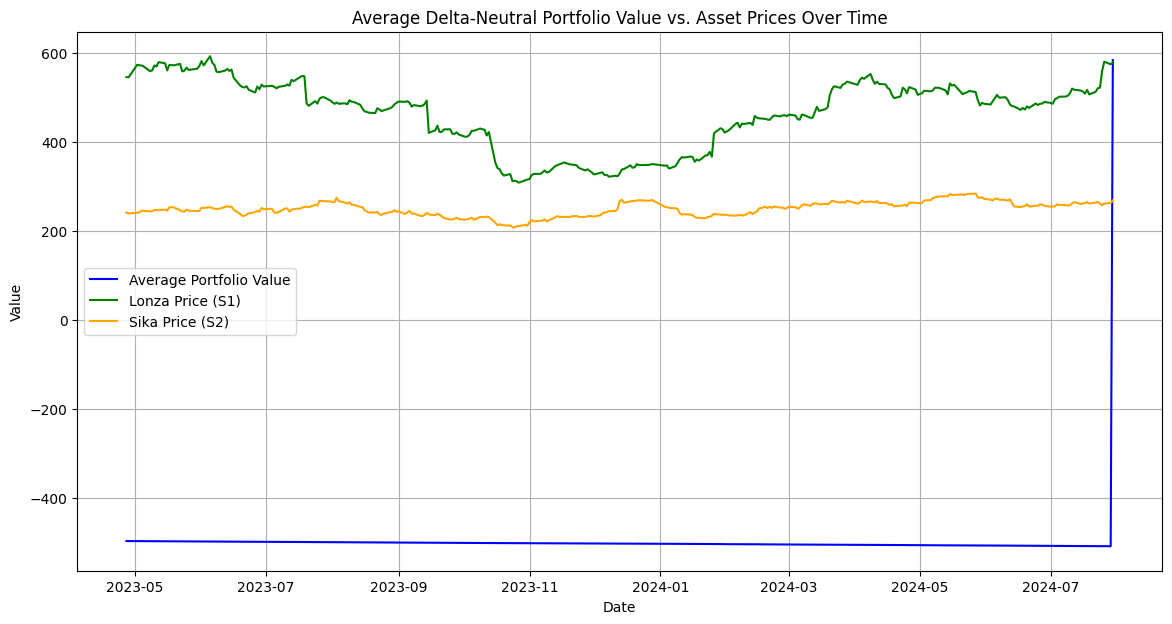

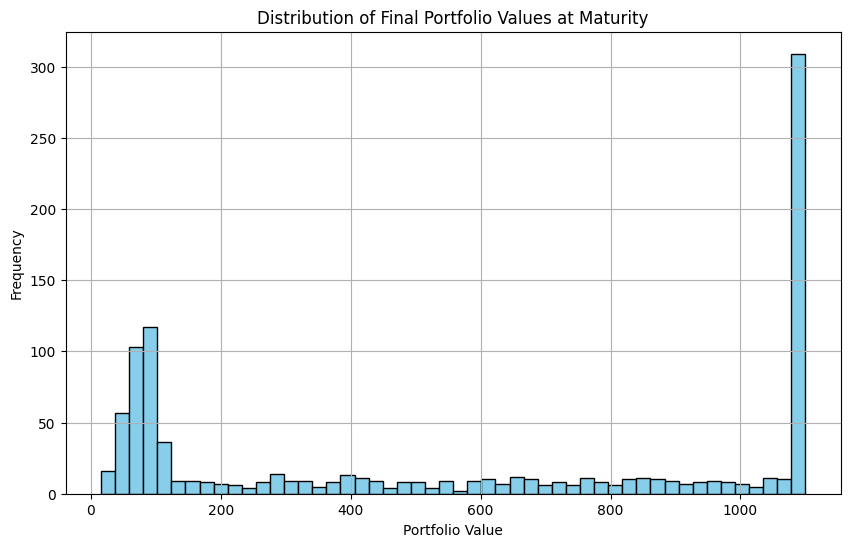

In [86]:
# Assuming you have already calculated portfolio_values_df

# Define your date list (ensure it aligns with lonza_paths and sika_paths)
date_list = lonza_path.index.tolist()

# Plot average portfolio vs. asset prices
plot_average_portfolio_vs_assets(portfolio_values_df, lonza_path, sika_path, date_list)

# Plot distribution of final portfolio values
plot_final_portfolio_distribution(portfolio_values_df)


In [45]:
payoff_perturbed(lonza_path, sika_path, params, cs.initial_fixing_date, h , 'Lonza')


array([1100., 1100., 1100., 1100., 1100., 1100., 1100., 1100., 1100.,
       1100.])

In [44]:

delta_sika

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
import numpy as np
import pandas as pd

# Assuming the following objects and functions are defined and imported elsewhere:
# - dates.get_list_dates(initial_date, final_date)
# - dates.num_business_days(start_date, end_date)
# - gbm.multi_asset_gbm_n_sims(plot, plotasset, nsims, data, fdos)
# - pf.payoff(lonza_path, sika_path, params_product, date)
# - payoff_perturbed(lonza_path, sika_path, params_product, date, h, perturb_assets)
# - calculate_greeks_multi_asset(lonza_path, sika_path, params_product, date, h, perturb_assets)
# - pp.productprice()
# - data: DataFrame indexed by date with columns ['S1', 'S2'] corresponding to Lonza and Sika
# - cs: Configuration/settings object with attributes:
#       - initial_fixing_date
#       - final_fixing_date
#       - interest_rate
#       - n_sims
# - h: Perturbation factor (e.g., 0.01 for 1%)
# - perturb_assets: List of assets to perturb (e.g., ['Lonza', 'Sika'])

# Step 1: Retrieve and Prepare the Date List
date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)

# Convert date_list to pandas Timestamps if they are not already
if isinstance(date_list[0], str):
    date_list = pd.to_datetime(date_list)

# Retrieve product prices as a DataFrame indexed by date
productprice_df = pp.product_price()

# Retrieve the risk-free interest rate
r = cs.interest_rate

# Initialize list to store portfolio values
portfolio_value_list = []

# Convert date_list to a list if it's not already (for slicing)
date_list = pd.Series(date_list).tolist()


# slice date list
date_list = date_list[-120:]  # Adjust the number as needed for production

# Define product parameters
params_product = {
    'Denomination': 1000,
    'Coupon_Rate': 0.08 / 4,  # Quarterly coupon payments
}

# Iterate over each date to calculate portfolio values
for fdos in date_list:
    try:
        # Ensure 'date' is a pd.Timestam
        
        # Calculate discount factor based on business days remaining
        T_discount = dates.num_business_days(fdos, cs.final_fixing_date) / 252  # Assuming 252 trading days in a year
        
        # Simulate asset paths using the provided GBM function
        sim_T = multi_asset_gbm_n_sims(
            plot=False,
            plotasset=False,
            nsims=10,
            data=data,
            fdos=fdos
        )
        
        # Extract asset paths as NumPy arrays for vectorized operations
        lonza_path = sim_T['LONN.SW'] # Ensure it's a NumPy array
        sika_path = sim_T['SIKA.SW']    # Ensure it's a NumPy array
        
        # Calculate payoffs for the derivative
        payoff_T = pf.payoff(lonza_path, sika_path, params_product, fdos)  # Vectorized operation
        

        # Calculate greeks (delta) for each asset
        delta_lonza = calculate_greeks(lonza_path, sika_path, params, fdos, h, 'Lonza')
        delta_sika = calculate_greeks(lonza_path, sika_path, params, fdos, h, 'Sika')

        
        # Calculate discounted mean deltas as holdings
        mean_delta_lonza = np.exp(-r * T_discount) * np.mean(delta_lonza)
        mean_delta_sika = np.exp(-r * T_discount) * np.mean(delta_sika)
        
        # Retrieve product price for the current date
        product_price = productprice_df.loc[fdos]
        
        # Retrieve realized asset prices for S1 and S2 using explicit column names
        S1_realized = data.loc[fdos, 'LONN.SW']  # Replace 'S1' with the actual column name if different
        S2_realized = data.loc[fdos, 'SIKA.SW']  # Replace 'S2' with the actual column name if different
        
        # Calculate portfolio value: θ = P - δ1 * S1 - δ2 * S2
        portfolio_value = product_price - (mean_delta_lonza * S1_realized) - (mean_delta_sika * S2_realized)
        
        # Append the portfolio value to the list
        portfolio_value_list.append(portfolio_value)
    
    except Exception as e:
        # Handle any exceptions (e.g., missing data) and append NaN
        print(f"Error processing date {fdos}: {e}")
        portfolio_value_list.append(np.nan)

# Convert the list of portfolio values into a DataFrame indexed by date
portfolio_values_df = pd.DataFrame({
    'Portfolio_Value': portfolio_value_list
}, index=date_list)

# Optionally, handle any NaN values (e.g., drop or fill)
portfolio_values_df.dropna(inplace=True)  # Drops rows with NaN values

# Display the first few portfolio values
print(portfolio_values_df.head())

# Optional: Save the portfolio values to a CSV for further analysis
# portfolio_values_df.to_csv('portfolio_values.csv')


Length of date_list: 120
Number of time steps (num_steps): 120
Length of date_list: 119
Number of time steps (num_steps): 119
Length of date_list: 118
Number of time steps (num_steps): 118
Length of date_list: 117
Number of time steps (num_steps): 117
Length of date_list: 116
Number of time steps (num_steps): 116
Length of date_list: 115
Number of time steps (num_steps): 115
Length of date_list: 114
Number of time steps (num_steps): 114
Length of date_list: 113
Number of time steps (num_steps): 113
Length of date_list: 112
Number of time steps (num_steps): 112
Error processing date 2024-02-19 00:00:00: Timestamp('2024-02-19 00:00:00')
Length of date_list: 111
Number of time steps (num_steps): 111
Length of date_list: 110
Number of time steps (num_steps): 110
Length of date_list: 109
Number of time steps (num_steps): 109
Length of date_list: 108
Number of time steps (num_steps): 108
Length of date_list: 107
Number of time steps (num_steps): 107
Error processing date 2024-02-26 00:00:00:

In [48]:
sim_Tt = multi_asset_gbm_n_sims(
        plot=False,
        plotasset=False,
        nsims=10,
        data=data,
        fdos=cs.initial_fixing_date
    )

Length of date_list: 315
Number of time steps (num_steps): 315


In [50]:
lonza_patht = sim_Tt['LONN.SW'] # Ensure it's a NumPy array
sika_patht = sim_Tt['SIKA.SW'] 


In [52]:
calculate_greeks(lonza_patht, sika_patht, params, cs.initial_fixing_date, h, 'Sika')

array([0.        , 3.70609217, 0.33085727, 0.        , 0.18087338,
       4.11015363, 3.60593148, 0.        , 0.        , 0.        ])

<Axes: xlabel='Date'>

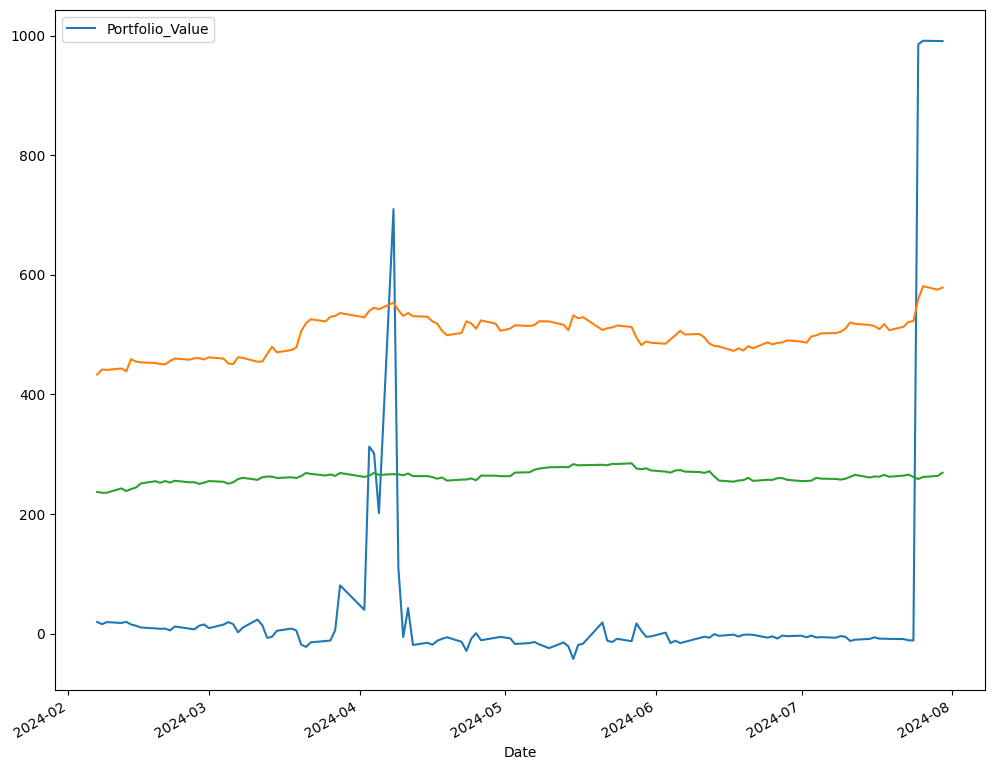

In [37]:
fig, ax = plt.subplots(figsize=(12, 10))
portfolio_values_df.plot(ax = ax)
data.iloc[-120:, 0].plot(ax = ax)
data.iloc[-120:, 1].plot(ax = ax)